# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [34]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import conll17_ud_eval as las

import time
import re
from collections import Counter
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [2]:
def read_conllu(conllu_filename, features_enabled=[0, 3, 6, 7], root=[0, 'ROOT', 0, 'root']):
    sentences = []

    features = ['INDEX', 'FORM', 'LEMMA', 'POS', 'X1', 'MORPHO', 'GOV', 'LABEL', 'X2', 'X3']

    columns = []
    for i, f in enumerate(features):
        if i in features_enabled:
            columns.append(f)

    with open(conllu_filename, 'r', encoding='utf-8') as conllu_file:
        sentence = []
        for i in range(len(features_enabled)):
            sentence.append([root[i]])
        for line in conllu_file:
            if line[0] == '\n':
                if len(sentence) > 1:
                    sentences.append(np.array(sentence).T)
                    sentence = []
                    for i in range(len(features_enabled)):
                        sentence.append([root[i]])
            elif line[0] != '#':
                tokens = line.split('\t')
                if '-' not in tokens[0]:
                    for i, j in enumerate(features_enabled):
                        sentence[i].append(tokens[j])
    return sentences

In [3]:
index_i = 0
pos_i = 1
governor_i = 2
label_i = 3

sentences = read_conllu("UD_French-GSD/fr_gsd-ud-dev.conllu")
sentence = sentences[0]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,PROPN,0,root
2,2,PUNCT,1,punct
3,3,DET,4,det
4,4,NOUN,1,appos
5,5,ADP,7,case
6,6,DET,7,det
7,7,NOUN,4,nmod
8,8,ADP,9,case
9,9,PROPN,7,nmod


### Projectivity

In [13]:
def is_projective(sentence):
    edges = []
    for w1 in sentence:
        if w1[index_i] == '0':
            continue
        
        i, j = int(w1[index_i]), int(w1[governor_i])
        
        if j < i:
            i, j = j, i
        
        for (i2, j2) in edges:
            i_in = False
            j_in = False
            
            if i == i2 or i == j2 or j == i2 or j == j2:
                continue
            
            if i2 <= i <= j2:
                i_in = True
            if i2 <= j <= j2:
                j_in = True
            
            if i_in != j_in:
#                 print(i, j, i2, j2)
                return False
            
        edges.append((i, j))
    return True

is_projective(sentence)

True

In [14]:
counter_p = 0
for s in sentences:
    if not is_projective(s):
        counter_p += 1
counter_p, '%.2f %%' % (counter_p / len(sentences) * 100)

(1169, '8.03 %')

### Creating dataset

Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in `create_example()`. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

In [3]:
pos_2_1hot = {
    'ADJ': 1,
    'ADP': 2,
    'ADV': 3,
    'AUX': 4,
    'CCONJ': 5,
    'DET': 6,
    'INTJ': 7,
    'NOUN': 8,
    'NUM': 9,
    'PART': 10,
    'PRON': 11,
    'PROPN': 12,
    'PUNCT': 13,
    'SCONJ': 14,
    'SYM': 15,
    'VERB': 16,
    'X': 17,
    'ROOT': 0
}

labels_2_1hot = {
    'acl': 0,
    'advcl': 1,
    'advmod': 2,
    'amod': 3,
    'appos': 4,
    'aux': 5,
    'case': 6,
    'cc': 7,
    'ccomp': 8,
    'clf': 9,
    'compound': 10,
    'conj': 11,
    'cop': 12,
    'csubj': 13,
    'dep': 14,
    'det': 15,
    'discourse': 16,
    'dislocated': 17,
    'expl': 18,
    'fixed': 19,
    'flat': 20,
    'goeswith': 21,
    'iobj': 22,
    'list': 23,
    'mark': 24,
    'nmod': 25,
    'nsubj': 26,
    'nummod': 27,
    'obj': 28,
    'obl': 29,
    'orphan': 30,
    'parataxis': 31,
    'punct': 32,
    'reparandum': 33,
    'root': 34,
    'vocative': 35,
    'xcomp': 36
}
onehot_2_label = {v: k for k, v in labels_2_1hot.items()}

def create_example(w1, w2, positive=True):
    dist = int(w2[index_i]) - int(w1[index_i])

    pos1 = np.zeros(len(pos_2_1hot))
    pos1[pos_2_1hot[w1[pos_i]]] = 1

    pos2 = np.zeros(len(pos_2_1hot))
    pos2[pos_2_1hot[w2[pos_i]]] = 1
    
    x = np.concatenate(([dist], pos1, pos2))
    label = np.zeros(37)
    
    y = [0, 0]
    if positive:
        if w1[governor_i] == w2[index_i]:
            g, d = w2, w1
            y[0] = 1
        else:
            d, g = w2, w1
            y[1] = 1
        l = d[label_i].split(':', 1)[0]
        label[labels_2_1hot[l]] = 1
    return x, np.concatenate((y, label))

def create_dataset(sentences, with_negatives=False):
    x = []
    y = []
    for s in sentences:
        for w1 in s:
            if w1[index_i] == '0':
                continue
            w2 = s[int(w1[governor_i])]
            
            if w1[index_i] > w2[index_i]:
                w2, w1 = w1, w2

            x_token, y_token = create_example(w1, w2)

            x.append(x_token)
            y.append(y_token)
            
            if with_negatives:
                i = np.random.randint(len(s) - 2)
                if i >= int(w1[index_i]):
                    i += 1
                if i >= int(w2[index_i]):
                    i += 1
                w2_negative = s[i]
                x_token, y_token = create_example(w1, w2, False)
                x.append(x_token)
                y.append(y_token)

    return np.array(x), np.array(y)

### With negatives

In [16]:
x, y = create_dataset(sentences, True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x.shape, y.shape

((713276, 37), (713276, 39))

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))

model.compile('sgd', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


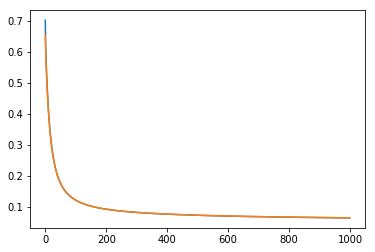

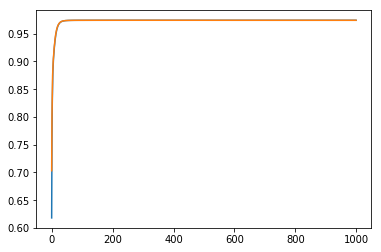

In [18]:
h = model.fit(x_train, y_train, epochs=1000, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### Without negatives

In [5]:
x, y = create_dataset(sentences)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x.shape, y.shape

((35768, 37), (35768, 39))

In [45]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model2.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


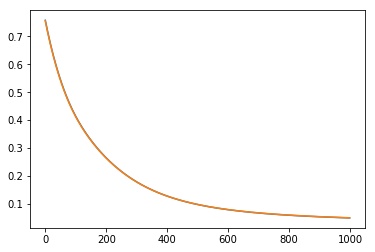

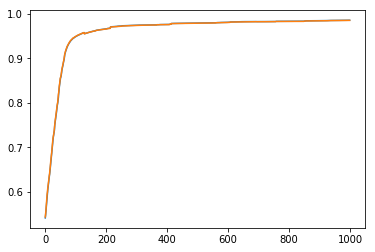

In [46]:
h = model2.fit(x_train, y_train, epochs=1000, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### Some tests

In [28]:
for s in sentence:
    print(s)
    x, _ = create_example(s, sentence[int(s[governor_i])])
    prediction = model.predict(x.reshape(1, -1))[0]
    prediction2 = model2.predict(x.reshape(1, -1))[0]

    i = np.argmax(prediction[2:])
    label = onehot_2_label[i]
    print('With negatives :', label, prediction[i+2], prediction[:2])
    
    i2 = np.argmax(prediction2[2:])
    label2 = onehot_2_label[i]
    print('Without negatives :', label2, prediction2[i2+2], prediction2[:2], '\n')

['0' 'ROOT' '-1' 'root']
With negatives : punct 0.38049737 [0.04562197 0.5292494 ]
Without negatives : punct 0.54920024 [0.07543957 0.92821574] 

['1' 'ADV' '5' 'advmod']
With negatives : advmod 0.07375645 [0.4334017  0.07728563]
Without negatives : advmod 0.12130801 [0.7625777  0.21682969] 

['2' 'PUNCT' '5' 'punct']
With negatives : punct 0.28252876 [0.45049548 0.05430106]
Without negatives : punct 0.5263443 [0.83914256 0.14809519] 

['3' 'DET' '4' 'det']
With negatives : det 0.4487391 [0.5037005  0.03339435]
Without negatives : det 0.8186691 [0.9242813  0.07625944] 

['4' 'NOUN' '5' 'nsubj']
With negatives : nsubj 0.057811584 [0.17219006 0.24131866]
Without negatives : nsubj 0.12208192 [0.43300888 0.579942  ] 

['5' 'VERB' '0' 'root']
With negatives : obl 0.12518024 [0.10288505 0.45387945]
Without negatives : obl 0.22398937 [0.23230016 0.7451881 ] 

['6' 'DET' '7' 'det']
With negatives : det 0.4487391 [0.5037005  0.03339435]
Without negatives : det 0.8186691 [0.9242813  0.07625944] 

### Eisner's algorithm

Now we have our model, we can use it to create the dependency parsing itself with Eisner's algorithm. 

[Explanatory video](https://youtu.be/du9VQaFEyeA)

In [4]:
def eisner(sentence, model=None, perfect=False):
    n = sentence.shape[0]

    full_left = []
    full_right = []
    part_left = []
    part_right = []
    
    part_max = []
    full_left_max = []
    full_right_max = []
    
    labels = []
    
    for i in range(n):
        full_left.append([0])
        full_right.append([0])
        part_left.append([0])
        part_right.append([0])
        
        part_max.append([0])
        full_left_max.append([0])
        full_right_max.append([0])
        
        labels.append([])

    for m in range(1, n):
        for i1 in range(n - m):
            i2 = i1 + m
            
            if perfect:
                prediction = np.zeros(39)
                prediction[0] = 0
                prediction[1] = 0
                label = None
                if sentence[i1][governor_i] == sentence[i2][index_i]:
                    prediction[0] = 1
                    label = sentence[i1][label_i]
                elif sentence[i2][governor_i] == sentence[i1][index_i]:
                    prediction[1] = 1
                    label = sentence[i2][label_i]
            else:
                x, _ = create_example(sentence[i1], sentence[i2])
                prediction = model.predict(x.reshape(1, -1))[0]

                i = np.argmax(prediction[2:])
                label = onehot_2_label[i]
                
            labels[i1].append(label)

            max_full = -1
            max_q = -1
            for q in range(i2 - i1):
                q_line = q + i1
                current = full_left[i1][q] + full_right[q_line + 1][i2 - q_line - 1]
                
                if current > max_full:
                    max_full = current
                    max_q = q_line
            
            part_left[i1].append(max_full + prediction[1])
            part_right[i1].append(max_full + prediction[0])
            part_max[i1].append(max_q)
            
            max_full_l = -1
            max_full_r = -1
            max_q_l = -1
            max_q_r = -1
            for q in range(i2 - i1):
                q_line = q + i1
                current_r = full_right[i1][q] + part_right[q_line][i2 - q_line]
                current_l = part_left[i1][q + 1] + full_left[q_line + 1][i2 - q_line - 1]

                if current_l > max_full_l:
                    max_full_l = current_l
                    max_q_l = q_line + 1
                if current_r > max_full_r:
                    max_full_r = current_r
                    max_q_r = q_line

            full_left[i1].append(max_full_l)
            full_right[i1].append(max_full_r)
            full_left_max[i1].append(max_q_l)
            full_right_max[i1].append(max_q_r)
                        
    return full_left_max, full_right_max, part_max, labels

In [12]:
full_left, full_right, part, labels = eisner(sentence, model)
full_left_n, full_right_n, part_n, labels_n = eisner(sentence, model2)
true_full_left, true_full_right, true_part, true_labels = eisner(sentence, perfect=True)

### Results

In [135]:
def color(val):
    if val:
        color = 'green'
    else:
        color = 'red'
    return 'background-color: %s' % color

def compare(tab1, tab2):
    df = (tab1 == tab2) | tab2.isnull()
    return df.style.applymap(color)

In [136]:
compare(pd.DataFrame(full_left), pd.DataFrame(true_full_left))

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,True,True,True,True
1,True,True,False,False,True,True,True,True,True
2,True,True,True,False,False,False,False,True,True
3,True,True,False,False,False,False,True,True,True
4,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [137]:
compare(pd.DataFrame(full_left_n), pd.DataFrame(true_full_left))

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False,True
2,True,True,True,False,False,False,False,True,True
3,True,True,False,False,False,False,True,True,True
4,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [138]:
compare(pd.DataFrame(full_right), pd.DataFrame(true_full_right))

,0,1,2,3,4,5,6,7,8
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True
3,True,True,False,False,False,False,True,True,True
4,True,True,False,False,False,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [139]:
compare(pd.DataFrame(full_right_n), pd.DataFrame(true_full_right))

,0,1,2,3,4,5,6,7,8
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,False,False,False,True
2,True,True,True,True,False,False,False,True,True
3,True,True,False,False,False,False,True,True,True
4,True,True,False,False,False,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [140]:
compare(pd.DataFrame(part), pd.DataFrame(true_part))

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,False,True,False,True
1,True,True,True,True,True,False,True,False,True
2,True,True,True,True,False,True,False,True,True
3,True,True,True,True,True,True,True,True,True
4,True,True,False,False,False,True,True,True,True
5,True,True,False,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [141]:
compare(pd.DataFrame(part_n), pd.DataFrame(true_part))

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,False,True,True,True
1,True,True,True,True,True,False,True,False,True
2,True,True,True,True,False,True,False,True,True
3,True,True,True,True,True,False,True,True,True
4,True,True,False,False,False,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True


In [142]:
compare(pd.DataFrame(labels), pd.DataFrame(true_labels))

,0,1,2,3,4,5,6,7
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
5,True,False,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True


In [143]:
compare(pd.DataFrame(labels_n), pd.DataFrame(true_labels))

,0,1,2,3,4,5,6,7
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
5,True,False,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True


### Decomposition

In [5]:
def decompose_full(sentence, i1, i2, full_left, full_right, part, labels, left=True):
#     print('full', left, i1, i2)
    if i1 < i2:
        if left:
            q = full_left[i1][i2 - i1]
            f1 = decompose_part
            f2 = decompose_full
        else:
            q = full_right[i1][i2 - i1]
            f1 = decompose_full
            f2 = decompose_part
        sentence = f1(sentence, i1, q, full_left, full_right, part, labels, left)
        sentence = f2(sentence, q, i2, full_left, full_right, part, labels, left)
    return sentence

def decompose_part(sentence, i1, i2, full_left, full_right, part, labels, left=True):
#     print('part', left, i1, i2)
    if left:
        sentence[i2][governor_i] = i1
        sentence[i2][label_i] = labels[i1][i2 - i1 - 1]
    else:
        sentence[i1][governor_i] = i2
        sentence[i1][label_i] = labels[i1][i2 - i1 - 1]
        
    if i1 < i2:
        q = part[i1][i2 - i1]
        sentence = decompose_full(sentence, i1, q, full_left, full_right, part, labels, True)
        sentence = decompose_full(sentence, q + 1, i2, full_left, full_right, part, labels, False)
    return sentence
        
def predict_sentence(sentence, full_left, full_right, part, labels):
    sentence_predicted = sentence.copy()
    for i in range(len(part[0])):
        part[0][i] = 0
    decompose_full(sentence_predicted, 0, len(sentence) - 1, full_left, full_right, part, labels)
    return sentence_predicted

In [201]:
sentence_predicted = predict_sentence(sentence, full_left, full_right, part, labels)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,-1,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,5,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,5,obl
7,7,NOUN,5,obl
8,8,PUNCT,5,punct


In [196]:
compare(pd.DataFrame(sentence_predicted)[[governor_i, label_i]], pd.DataFrame(sentence)[[governor_i, label_i]])

,2,3
0,True,True
1,True,True
2,True,True
3,False,True
4,True,True
5,True,True
6,False,False
7,True,False
8,True,True


In [199]:
sentence_predicted = predict_sentence(sentence, full_left_n, full_right_n, part_n, labels_n)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,-1,root
1,1,ADV,4,det
2,2,PUNCT,4,punct
3,3,DET,4,det
4,4,NOUN,0,root
5,5,VERB,4,nsubj
6,6,DET,7,det
7,7,NOUN,5,obl
8,8,PUNCT,5,punct


In [200]:
compare(pd.DataFrame(sentence_predicted)[[governor_i, label_i]], pd.DataFrame(sentence)[[governor_i, label_i]])

,2,3
0,True,True
1,False,False
2,False,True
3,True,True
4,False,False
5,False,False
6,True,True
7,True,False
8,True,True


### LAS scores

In [6]:
def predict_sentences(filename, model=None, features_enabled=[0, 3, 6, 7], root=[0, 'ROOT', 0, 'root'], perfect=False):
    sentences_test = read_conllu(filename, features_enabled, root)

    for s in range(len(sentences_test)):
        full_left, full_right, part, labels = eisner(sentences_test[s], model, perfect)
        sentences_test[s] = predict_sentence(sentences_test[s], full_left, full_right, part, labels)
    
    return sentences_test

def write_conllu(sentences, filename_in, filename_out):
#     features = ['INDEX', 'FORM', 'LEMMA', 'POS', 'X1', 'MORPHO', 'GOV', 'LABEL', 'X2', 'X3']
    with open(filename_in, 'r', encoding='utf-8') as fin, open(filename_out, 'w', encoding='utf-8') as fout:
        sentence_i = 0
        sentence_begin = True
        for line in fin:
            if line[0] == '\n':
                fout.write(line)
                if not sentence_begin:
                    sentence_i += 1
                    sentence_begin = True
            elif line[0] != '#':
                sentence_begin = False
                tokens = line.split('\t')
                if '-' in tokens[0]:
                    fout.write(line)
                    continue
                if int(tokens[0]) - 1 >= len(sentences[sentence_i]):
                    print(line)
                    print(sentences[sentence_i])
                    print(sentence_i)
                    break
                tokens[6] = sentences[sentence_i][int(tokens[0])][governor_i]
                tokens[7] = sentences[sentence_i][int(tokens[0])][label_i]
                fout.write('\t'.join(tokens))

def score_las(filename_test, filename_gold):
    score = 0
    with open(filename_test, 'r') as ftest, \
            open(filename_gold, 'r') as fgold:
        test = las.load_conllu(ftest)
        gold = las.load_conllu(fgold)
        score = las.evaluate(gold, test)['LAS'].f1
    return score

In [210]:
sentences_test = predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', model)
write_conllu(sentences_test, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test.conll')
score_las('fr_test.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.12315369261477047

In [47]:
sentences_test = predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', model2)
write_conllu(sentences_test, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_n.conll')
score_las('fr_test_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.10379241516966067

In [48]:
sentences_test = predict_sentences('UD_French-GSD/fr_gsd-ud-dev.conllu', model2)
write_conllu(sentences_test, 'UD_French-GSD/fr_gsd-ud-dev.conllu', 'fr_test_f2.conll')
score_las('fr_test_f2.conll', 'UD_French-GSD/fr_gsd-ud-dev.conllu')

0.10920375754864683

## F2 features

In [7]:
index_i = 0
lemma_i = 1
pos_i = 2
morpho_i = 3
governor_i = 4
label_i = 5

sentences = read_conllu("UD_French-GSD/fr_gsd-ud-dev.conllu", features_enabled=[0, 2, 3, 5, 6, 7], root=[0, 'ROOT', 'ROOT', '_', 0, 'root'])
sentence = sentences[0]
pd.DataFrame(sentence)

,0,1,2,3,4,5
0,0,ROOT,ROOT,_,0,root
1,1,Aviator,PROPN,_,0,root
2,2,",",PUNCT,_,1,punct
3,3,un,DET,Definite=Ind|Gender=Masc|Number=Sing|PronType=Art,4,det
4,4,film,NOUN,Gender=Masc|Number=Sing,1,appos
5,5,sur,ADP,_,7,case
6,6,le,DET,Definite=Def|Gender=Fem|Number=Sing|PronType=Art,7,det
7,7,vie,NOUN,Gender=Fem|Number=Sing,4,nmod
8,8,de,ADP,_,9,case
9,9,Hughes,PROPN,_,7,nmod


## Morphology Exploration

In [8]:
morphos = {}
no_morpho_count = 0
word_count = 0

for s in sentences:
    for w in s:
        word_count += 1
        if w[morpho_i] == '_':
            no_morpho_count += 1
            continue
        for m in w[morpho_i].split('|'):
            m = m.split('=')
            if m[0] not in morphos:
                morphos[m[0]] = Counter()
            morphos[m[0]][m[1]] += 1

In [271]:
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(17186, 37246, '46.14 %')

In [272]:
inputs_count = 0
for m in morphos:
    inputs_count += len(m)
inputs_count

80

In [273]:
morphos

{'Case': Counter({'Acc': 1, 'Nom': 1}),
 'Definite': Counter({'Def': 3993, 'Ind': 889}),
 'Gender': Counter({'Fem': 6758, 'Masc': 9117}),
 'Mood': Counter({'Cnd': 38, 'Imp': 15, 'Ind': 2113, 'Sub': 24}),
 'NumType': Counter({'Ord': 21}),
 'Number': Counter({'Plur': 4322, 'Sing': 14292}),
 'Person': Counter({'1': 168, '2': 50, '3': 3053}),
 'Polarity': Counter({'Neg': 232}),
 'Poss': Counter({'Yes': 357}),
 'PronType': Counter({'Art': 4878,
          'Dem': 321,
          'Neg': 8,
          'Prs': 1286,
          'Rel': 309}),
 'Reflex': Counter({'Yes': 6}),
 'Tense': Counter({'Fut': 82, 'Imp': 184, 'Past': 1199, 'Pres': 1915}),
 'VerbForm': Counter({'Fin': 2190, 'Inf': 525, 'Part': 1190})}

In [9]:
for s in sentences:
    for w in s:
        if 'Case' in w[morpho_i]:
            print(w)
            w[morpho_i] = re.sub('Case=(.+?)\|', '', w[morpho_i])

del morphos['Case']

['30' 'Krise' 'NOUN' 'Case=Acc|Gender=Fem|Number=Plur' '33' 'nmod']
['33' 'Verantwortung' 'NOUN' 'Case=Nom|Gender=Fem|Number=Plur' '22'
 'appos']


In [10]:
morphos_2_vec = {}

i = 0
for k, m in morphos.items():
    morphos_2_vec[k] = {}
    keys = m.keys()
    for k2 in m.keys():
        morphos_2_vec[k][k2] = i
        i += 1

morphos_2_vec

{'Definite': {'Def': 6, 'Ind': 7},
 'Gender': {'Fem': 5, 'Masc': 4},
 'Mood': {'Cnd': 2, 'Imp': 1, 'Ind': 3, 'Sub': 0},
 'NumType': {'Ord': 23},
 'Number': {'Plur': 10, 'Sing': 9},
 'Person': {'1': 13, '2': 12, '3': 11},
 'Polarity': {'Neg': 17},
 'Poss': {'Yes': 28},
 'PronType': {'Art': 19, 'Dem': 18, 'Neg': 20, 'Prs': 22, 'Rel': 21},
 'Reflex': {'Yes': 8},
 'Tense': {'Fut': 24, 'Imp': 26, 'Past': 25, 'Pres': 27},
 'VerbForm': {'Fin': 15, 'Inf': 16, 'Part': 14}}

In [11]:
def convert_morpho(w):
    result = np.zeros(78)
    if w[morpho_i] == '_':
        return result
    for m in w[morpho_i].split('|'):
        m = m.split('=')
        if m[0] == 'Case':
            continue
        result[morphos_2_vec[m[0]][m[1]]] = 1
    return result

print(sentence[3][morpho_i])
convert_morpho(sentence[3])

Definite=Ind|Gender=Masc|Number=Sing|PronType=Art


array([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Embeddings

In [8]:
txts = []
for s in sentences:
    txts.append(list(s.T[lemma_i]))
#     print(txts)
#     break

In [9]:
word2vec = Word2Vec(txts, size=100, window=5, min_count=1, workers=20, iter=13)

In [11]:
word2vec.most_similar('homme')

[(':', 0.9999552965164185),
 ('avec', 0.9999533891677856),
 ('pour', 0.9999516010284424),
 ('contre', 0.9999505281448364),
 ('en', 0.9999502301216125),
 ('dont', 0.9999480247497559),
 ('nouveau', 0.9999476671218872),
 ('par', 0.9999459981918335),
 ('tout', 0.9999454617500305),
 ('année', 0.9999446868896484)]

In [32]:
embeddings = {}

del word

with open('embeddings/fr.tsv', 'r') as f:
    i = 0
    for line in f:
        i += 1
        if line[0] != ' ':  # new word
            if 'word' in locals():
                embeddings[word] = np.array(vec, dtype=np.float)
            line = line.split('\t')
            word = line[1]
            vec = line[2].lstrip('[').split()
            continue
        
        vec = vec + line.strip(' ]\n').split()

In [63]:
def most_similar(word, n=10):
    vec = embeddings[word]
    top = []
    top_words = []
    for i in range(n):
        top.append(float('inf'))
        top_words.append('')

    cpt = 0
    for w, v in embeddings.items():
        if w == word:
            continue
        cpt += 1
        dist = cosine(vec, v)
        i = 0
        while i < len(top) and dist < top[i]:
            i += 1
        top = top[:i] + [dist] + top[i:]
        top = top[1:]
        top_words = top_words[:i] + [w] + top_words[i:]
        top_words = top_words[1:]

    return zip(reversed(top_words), reversed(top))

for w, d in most_similar('homme'):
    print(w, d)

aventurier 0.3812869298843866
aristocrate 0.41586075197264827
garçon 0.42669343291005124
vieillard 0.42848045450211325
délinquant 0.4517847652614828
écrivain 0.462098919208601
politicien 0.4643771199670472
escroc 0.46441918350310585
orateur 0.47624799682468577
érudit 0.4801901703996774


In [64]:
for w, d in most_similar('femme'):
    print(w, d)

servante 0.27001328890807663
mère 0.27587044941978245
fille 0.28304991668249113
belle-mère 0.3160642425882113
fiancée 0.32169272506347235
compagne 0.3242348885116416
sœur 0.3276623007064734
prostituée 0.3331958262205478
nourrice 0.334836847918482
demi-sœur 0.3499454120589943


In [71]:
mean_embedding = np.zeros(len(embeddings['homme']))
for w, v in embeddings.items():
    mean_embedding = mean_embedding + v
mean_embedding = mean_embedding / len(embeddings)
mean_embedding

array([-0.12279268, -0.03152323,  0.02692432,  0.20575323, -0.00715915,
       -0.11338488,  0.09811104, -0.14395304, -0.15429663,  0.02433338,
        0.00041616, -0.24001022,  0.01397932, -0.02483673,  0.04846362,
        0.08685455, -0.0624815 ,  0.10685858, -0.11915702,  0.02301157,
        0.06280479,  0.13148182, -0.01599961, -0.01124048,  0.02540488,
       -0.01076573,  0.05550246, -0.23327268, -0.20804333, -0.10331835,
       -0.06061271,  0.23067168, -0.06123794, -0.01594888,  0.08824471,
        0.0019857 ,  0.03532121,  0.10495324,  0.12145742, -0.00310171,
       -0.11807032,  0.16501602, -0.04846513,  0.01057957, -0.06139822,
       -0.15811344, -0.077792  , -0.16488602,  0.13981579,  0.0960588 ,
        0.0555431 , -0.07585501,  0.01799126, -0.09385321, -0.12897422,
       -0.04989071,  0.0851505 , -0.05359804,  0.06320066, -0.09043587,
       -0.02835805,  0.06673133, -0.03830634,  0.14070026,  0.03829991,
        0.07494576, -0.27610894, -0.02936218,  0.12528584, -0.14

## Data

In [72]:
def create_example(w1, w2, positive=True):
    dist = int(w2[index_i]) - int(w1[index_i])

    pos1 = np.zeros(len(pos_2_1hot))
    pos1[pos_2_1hot[w1[pos_i]]] = 1

    pos2 = np.zeros(len(pos_2_1hot))
    pos2[pos_2_1hot[w2[pos_i]]] = 1
    
    morpho1 = convert_morpho(w1)
    morpho2 = convert_morpho(w2)
    
    if w1[lemma_i] in embeddings:
        embedding1 = embeddings[w1[lemma_i]]
    else:
        embedding1 = mean_embedding
    if w2[lemma_i] in embeddings:
        embedding2 = embeddings[w2[lemma_i]]
    else:
        embedding2 = mean_embedding
    
    x = np.concatenate(([dist], pos1, pos2, morpho1, morpho2, embedding1, embedding2))
    label = np.zeros(37)
    
    y = [0, 0]
    if positive:
        if w1[governor_i] == w2[index_i]:
            g, d = w2, w1
            y[0] = 1
        else:
            d, g = w2, w1
            y[1] = 1
        l = d[label_i].split(':', 1)[0]
        label[labels_2_1hot[l]] = 1
    return x, np.concatenate((y, label))

In [73]:
x, y = create_dataset(sentences)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x.shape, y.shape

((35768, 793), (35768, 39))

## Model

In [78]:
modelf2 = keras.models.Sequential()
modelf2.add(keras.layers.Dense(393, activation='sigmoid', input_dim=793))
modelf2.add(keras.layers.Dense(150, activation='sigmoid'))
modelf2.add(keras.layers.Dense(39, activation='sigmoid'))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

modelf2.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
modelf2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 393)               312042    
_________________________________________________________________
dense_8 (Dense)              (None, 150)               59100     
_________________________________________________________________
dense_9 (Dense)              (None, 39)                5889      
Total params: 377,031
Trainable params: 377,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = modelf2.fit(x_train, y_train, epochs=400, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

## Eisner

In [80]:
sentences_test = predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', modelf2, features_enabled=[0, 2, 3, 5, 6, 7], root=[0, 'ROOT', 'ROOT', '_', 0, 'root'])
write_conllu(sentences_test, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f2.conll')
score_las('fr_test_f2.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.41387225548902196

In [81]:
sentences_test = predict_sentences('UD_French-GSD/fr_gsd-ud-dev.conllu', modelf2, features_enabled=[0, 2, 3, 5, 6, 7], root=[0, 'ROOT', 'ROOT', '_', 0, 'root'])
write_conllu(sentences_test, 'UD_French-GSD/fr_gsd-ud-dev.conllu', 'fr_test_f2.conll')
score_las('fr_test_f2.conll', 'UD_French-GSD/fr_gsd-ud-dev.conllu')

0.48330910310892417